In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import cv2
from ocr.ru import LangWrapper, Ru, Eu

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [7]:
ru_rec = LangWrapper(Ru())
eu_rec = LangWrapper(Eu())

Downloaded model path: /home/worker/workspace/tdbm-secure-cctv/pybooks/ocr/./data/./models/TextDetector/Eu/anpr_ocr_eu_2022_03_28_pytorch_lightning.ckpt


anpr_ocr_eu_2022_03_28_pytorch_lightning.ckpt: 13.9MB [00:03, 3.95MB/s]                                                                                       


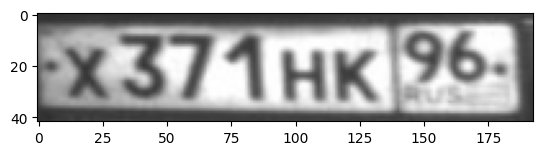

In [7]:
import matplotlib.pylab as plt
import numpy as np
from pathlib import Path

# image = cv2.imread('', cv2.IMREAD_GRAYSCALE)
# image = np.stack([image,image,image], axis=-1)
filenames = [str(s) for s in Path('../nomeroff-net/data/dataset/TextDetector/ocr_example/test/img/').glob('*')]
image = cv2.imread(str(filenames[0]))
plt.imshow(image)

In [9]:
res = ru_rec.predict_images([image])
res

['X371HK96']

In [10]:
res = eu_rec.predict_images([image])
res

['X371HK6']

In [11]:
preds = ru_rec.predict_filenames(filenames)

In [13]:
preds

['X371HK96', 'A2956669', 'T251KC77', 'A40013BM']

In [18]:
%%timeit

preds = eu_rec.predict_filenames(filenames[:1])
# preds

8.45 ms ± 82.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
import cv2
import base64
import numpy as np
import requests
import io
import json

def resize_image(image, desired_width):
    current_width = image.shape[1]
    scale_percent = desired_width / current_width
    width = int(image.shape[1] * scale_percent)
    height = int(image.shape[0] * scale_percent)
    resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    return resized

def compress_image(image, grayscale=True, desired_width=480):
    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = resize_image(image, desired_width)
    return image


def image_from_bytes(byte_im):
    nparr = np.frombuffer(byte_im, np.uint8)
    img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    return img_np

def image_from_base64(string: str):
    bytes_ = base64.b64decode(string.encode("utf-8"))
    return image_from_bytes(bytes_)


def image_to_jpeg_nparray(image, quality=[int(cv2.IMWRITE_JPEG_QUALITY), 95]):
    is_success, im_buf_arr = cv2.imencode(".jpg", image, quality)
    return im_buf_arr


def image_to_jpeg_bytes(image, quality=[int(cv2.IMWRITE_JPEG_QUALITY), 95]):
    buf = image_to_jpeg_nparray(image, quality)
    byte_im = buf.tobytes()
    return byte_im

def optimize_to_send(image, target_size=None):
    reduced = image.copy()
    if target_size is not None:
        reduced = compress_image(reduced, desired_width=target_size)
    byte_im = image_to_jpeg_bytes(reduced)
    # encode image
    img_enc = base64.b64encode(byte_im).decode("utf-8")
    img_dump = {"img_base64": img_enc}
#     img_dump = json.dumps({"img_base64": img_enc})
    return img_dump

In [59]:
import requests

def lp_result_from_response(response):
    dct = json.loads(response.content.decode('utf-8'))
    assert dct.get('success')
    assert dct.get('predictions') is not None
    
    return dct['predictions']['license_plate']

def df_results_from_response(response):
    dct = json.loads(response.content.decode('utf-8'))
    assert dct.get('success')
    assert dct.get('predictions') is not None
    
    locations = []
    embeddings = []
    for rec in dct['predictions']:
        locations.append(rec['location'])
        embeddings.append(rec['embedding'])
    return locations, embeddings

def ef_results_from_response(response):
    dct = json.loads(response.content.decode('utf-8'))
    assert dct.get('success')
    assert dct.get('predictions') is not None
    return dct['predictions']['embedding']

def process_lp_request(image):
    send_ = optimize_to_send(image)
    response = requests.post('http://ml.n19:11080/license_plate', data=send_)
    return lp_result_from_response(response)

def process_det_face_request(image):
    send_ = optimize_to_send(image, 480)
    response = requests.post('http://ml.n19:11080/detect_face', data=send_)
    locations, embeddings = df_results_from_response(response)
    return send_['img_base64'], locations, embeddings

def process_rec_face_request(image):
    send_ = optimize_to_send(image, 112)
    response = requests.post('http://ml.n19:11080/embed_face', data=send_)
    embeddings = ef_results_from_response(response)
    return embeddings

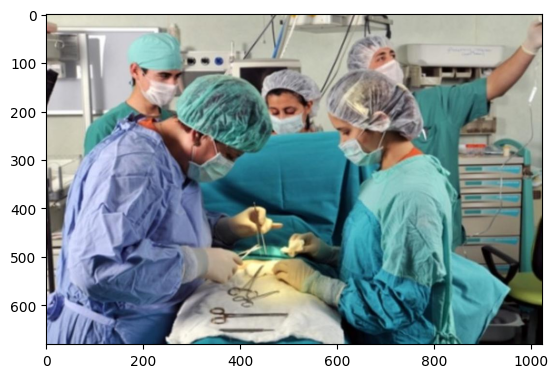

In [99]:
face_image = cv2.cvtColor(cv2.imread('30_Surgeons_Surgeons_30_10.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.imshow(face_image)

In [96]:
# %%timeit
res, lloc, lemb = process_det_face_request(face_image)

In [97]:
lloc

[]

In [87]:
loc = lloc[0]
extr_face = image_from_base64(res)[loc[1]:loc[1]+loc[3], loc[0]:loc[0]+loc[2]]
extr_face = np.stack([extr_face,extr_face,extr_face], axis=-1)
plt.imshow(extr_face)

IndexError: list index out of range

In [81]:
%%timeit

remb = process_rec_face_request(extr_face)

292 ms ± 45.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
from sklearn.metrics import pairwise_distances

In [78]:
rvec = np.random.uniform(0,1, size=512)

In [76]:
max(remb)

0.5901166200637817

In [80]:
pairwise_distances([remb, lemb[0], rvec])

array([[ 0.        ,  0.54387135, 14.2575788 ],
       [ 0.54387135,  0.        , 14.18650549],
       [14.2575788 , 14.18650549,  0.        ]])

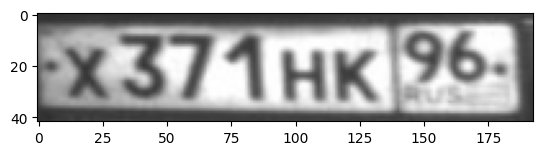

In [21]:
plt.imshow(image)

In [20]:
process_request(image)

'X371HK6'

In [19]:
%%timeit
process_request(image)

120 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
